## <p style="text-align: center;">Cell Counting with Microscope Images of Microglia </p>
<p style="text-align: center;">By Brendan Winn</p>

### Introduction
Here we go through the model building process. Unfortunately, we have relatively few labeled samples, so that leaves us stuck with using transfer learning, rather than building a model from scratch. Our goal is to produce bounding boxes for cells (and anything that 'looks' like a cell) from a base image. There are multiple objects to that need bounding boxes in most of the images. Some examples will be given in the data visualization step.

#### For Background
The model we end up using for object dectection (`sdd300_vgg16`) is the subject of a very nice tutorial here: [sgrvinod/a-PyTorch-Tutorial-to-Object-Detection](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection). I highly recommend reading through this if you want more information about the model's mechanics.

### Loaders and Preprocessing
The images have already been preprocessed (there's another notebook showing that process), so the only thing left to do with them are to resize to a standard resolution, and to normalize. The labels will require slightly more work, as they reside in a CSV file and will need to be translated into a form PyTorch can use.

In [1]:
# Step 1 -- Loaders and preprocessing

# First, we grab the images and their labels.
import os
image_count = 100 # Number of images with labels
image_path = 'data/processed_split/'

def get_images(image_path, image_count, image_offset=0):
    images = [image_path + f for f in os.listdir(image_path) if f[-4:]=='.png' and int(f[:-4]) <= image_count + image_offset]
    images.sort()
    images = [(image_number + 1 + image_offset, image_path) for image_number, image_path in enumerate(images)]
    return images
    
training_images = get_images(image_path, image_count)
print(training_images)

[(1, 'data/processed_split/0001.png'), (2, 'data/processed_split/0002.png'), (3, 'data/processed_split/0003.png'), (4, 'data/processed_split/0004.png'), (5, 'data/processed_split/0005.png'), (6, 'data/processed_split/0006.png'), (7, 'data/processed_split/0007.png'), (8, 'data/processed_split/0008.png'), (9, 'data/processed_split/0009.png'), (10, 'data/processed_split/0010.png'), (11, 'data/processed_split/0011.png'), (12, 'data/processed_split/0012.png'), (13, 'data/processed_split/0013.png'), (14, 'data/processed_split/0014.png'), (15, 'data/processed_split/0015.png'), (16, 'data/processed_split/0016.png'), (17, 'data/processed_split/0017.png'), (18, 'data/processed_split/0018.png'), (19, 'data/processed_split/0019.png'), (20, 'data/processed_split/0020.png'), (21, 'data/processed_split/0021.png'), (22, 'data/processed_split/0022.png'), (23, 'data/processed_split/0023.png'), (24, 'data/processed_split/0024.png'), (25, 'data/processed_split/0025.png'), (26, 'data/processed_split/0026.p

In [2]:
# Labels need to be extracted from a csv
import pandas as pd
training_data_labels='data/hand_labels.csv'
df = pd.read_csv(training_data_labels)
df

,metadata_id,file_list,flags,temporal_coordinates,spatial_coordinates,metadata
0,1_62qrINeA,"[""0001.png""]",0,[],"[2,164.928,179.318,57.559,38.741]",{}
1,1_XrIlywjG,"[""0001.png""]",0,[],"[2,125.08,394.056,53.131,56.452]",{}
2,1_tFE2BJgV,"[""0001.png""]",0,[],"[2,243.518,647.536,49.81,59.773]",{}
3,1_Yoiy1pR2,"[""0001.png""]",0,[],"[2,940.864,324.321,48.704,61.987]",{}
4,1_2si7l6gq,"[""0001.png""]",0,[],"[2,1067.051,419.515,47.596,85.231]",{}
...,...,...,...,...,...,...
2538,5_aaWJVBSU,"[""0005.png""]",0,[],"[2,1641.342,580.569,74.115,66.395]",{}
2539,4_EoX1yWeK,"[""0004.png""]",0,[],"[2,3.08854,1215.17959,50.954,41.69]",{}
2540,3_3WVBqIX8,"[""0003.png""]",0,[],"[2,1327.897,1070.552,121.809,84.066]",{}
2541,1_oqiUxuNZ,"[""0001.png""]",0,[],"[2,355.135,955.60511,75.488,66.91]",{}


In [3]:
# We want the file list and the spatial coordinates. The coordinates are of the form [shape, x, y, w, h].
# We'll parse them into tuples (file_name, (x1, y1, x2, y2), (fx, fy, fw, fh), (cx, cy, cw, ch)) where:
#    index              = File number
#    file_name          = Relative path to file
#    x1, y1, x2, y2     = Absolute coordinates of the bounding box
#    fx1, fy1, fx2, fy2 = Fractional coordinates, e.g. fx = x1/image_width
#    cx, cy, cw, ch     = Center-Size coordinates, like fractional coordinates but with factional width and height
# Most Pytorch models expect fractional coordinates, but we may find use for these other coordinate forms.

import torchvision     # For image processing and models
from tqdm import tqdm  # For progress bars

def get_bounding_boxes(csv):
    df = pd.read_csv(csv)
    df = df[['file_list','spatial_coordinates']]
    bboxes = []
    for _, row in tqdm(df.iterrows(), total=len(df), ncols=100):
    
        file = row['file_list']
        file = file.strip(' ["]')
        file_id = int(file[:-4])
        file_path = image_path + file
        coords = row['spatial_coordinates']
        coords = coords.strip('[]').split(',')
        coords = [float(coord) for coord in coords]
    
        # Boundary Coordinates
        x1 = coords[1]
        y1 = coords[2]
        x2 = coords[3] + coords[1]
        y2 = coords[4] + coords[2]
    
        image = torchvision.io.read_image(file_path, mode=torchvision.io.ImageReadMode.GRAY)
        _, image_height, image_width = image.size()
    
        # Fractional Coordinates
        fx1 = x1/float(image_width)
        fy1 = y1/float(image_height)
        fx2 = x2/float(image_width)
        fy2 = y2/float(image_height)
    
        # Center-Size Coordinates
        cx = fx1
        cy = fy1
        cw = fx2 - fx1
        ch = fy2 - fy1
    
        bbox = (file_id, file_path, (x1, y1, x2, y2), (fx1, fy1, fx2, fy2),(cx, cy, ch, cw))
        bboxes.append(bbox)
    
    bboxes.sort()
    return bboxes

training_bboxes = get_bounding_boxes(training_data_labels)
training_bboxes

100%|███████████████████████████████████████████████████████████| 2543/2543 [01:21<00:00, 31.09it/s]


[(1,
  'data/processed_split/0001.png',
  (58.331, 291.657, 120.094, 403.173),
  (0.03012964876033058,
   0.19976506849315068,
   0.06203202479338843,
   0.2761458904109589),
  (0.03012964876033058,
   0.19976506849315068,
   0.0763808219178082,
   0.031902376033057844)),
 (1,
  'data/processed_split/0001.png',
  (81.911, 140.576, 162.714, 194.814),
  (0.04230940082644628,
   0.09628493150684932,
   0.08404648760330578,
   0.13343424657534247),
  (0.04230940082644628,
   0.09628493150684932,
   0.03714931506849316,
   0.0417370867768595)),
 (1,
  'data/processed_split/0001.png',
  (125.08, 394.056, 178.211, 450.508),
  (0.06460743801652892,
   0.26990136986301366,
   0.09205113636363638,
   0.3085671232876712),
  (0.06460743801652892,
   0.26990136986301366,
   0.038665753424657556,
   0.027443698347107456)),
 (1,
  'data/processed_split/0001.png',
  (164.928, 179.318, 222.487, 218.05900000000003),
  (0.0851900826446281,
   0.12282054794520549,
   0.11492097107438017,
   0.149355479452

In [4]:
# That's good, but we need to collect all the bounding boxes for a given image.

def collect_bounding_boxes(images, bboxes):
    labels = {}
    for image in tqdm(images, total=len(images), ncols=100):
        image_bboxes = list(filter(lambda x: image[0] == x[0], bboxes))
        file_id = image[0]
        bounding_boxes = []
        for bbox in image_bboxes:
            bbox = bbox[2:]
            bounding_boxes.append({
                'boundary_coordinates': bbox[0],
                'fractional_coordinates': bbox[1],
                'centerwise_coordinates': bbox[2],
            })
        labels[file_id] = bounding_boxes
    return labels

training_labels = collect_bounding_boxes(training_images, training_bboxes)
    
image_number = 1
bounding_box_number = 1
print('Bounding boxes for image 0001:', len(training_labels[image_number]))
print('Fractional coordinates for the first bbox in 0001:', training_labels[image_number][bounding_box_number]['fractional_coordinates'])

100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 5390.30it/s]

Bounding boxes for image 0001: 32
Fractional coordinates for the first bbox in 0001: (0.04230940082644628, 0.09628493150684932, 0.08404648760330578, 0.13343424657534247)


In [5]:
# Some separate validation data
validation_images = get_images(image_path='data/validation_images/', image_count=20, image_offset=999)
validation_bboxes = get_bounding_boxes('data/validation_labels.csv')
validation_labels = collect_bounding_boxes(
    images=validation_images,
    bboxes=validation_bboxes
)

100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 13019.72it/s]


In [6]:
print(validation_labels)

{1000: [{'boundary_coordinates': (148.967, 654.892, 193.93800000000002, 694.2420000000001), 'fractional_coordinates': (0.08546586345381527, 0.49839573820395744, 0.11126678141135973, 0.5283424657534247), 'centerwise_coordinates': (0.08546586345381527, 0.49839573820395744, 0.029946727549467256, 0.025800917957544467)}, {'boundary_coordinates': (227.666, 1207.194, 272.637, 1247.949), 'fractional_coordinates': (0.13061732644865176, 0.9187168949771689, 0.15641824440619623, 0.9497328767123289), 'centerwise_coordinates': (0.13061732644865176, 0.9187168949771689, 0.03101598173515996, 0.025800917957544467)}, {'boundary_coordinates': (258.584, 913.476, 290.907, 952.826), 'fractional_coordinates': (0.14835570854847963, 0.6951872146118722, 0.16690017211703959, 0.7251339421613394), 'centerwise_coordinates': (0.14835570854847963, 0.6951872146118722, 0.029946727549467256, 0.01854446356855996)}, {'boundary_coordinates': (304.96, 713.917, 341.49899999999997, 760.293), 'fractional_coordinates': (0.174962

In [7]:
# Some separate testing data
testing_images = get_images(image_path='data/test_images/', image_count=20, image_offset=1801)
testing_bboxes = get_bounding_boxes('data/test_labels.csv')
testing_labels = collect_bounding_boxes(
    images=testing_images,
    bboxes=testing_bboxes
)

100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 22239.15it/s]


In [8]:
print(testing_labels)

{1802: [{'boundary_coordinates': (35.134, 348.526, 89.94200000000001, 380.849), 'fractional_coordinates': (0.018147727272727274, 0.2652404870624049, 0.046457644628099176, 0.2898394216133942), 'centerwise_coordinates': (0.018147727272727274, 0.2652404870624049, 0.024598934550989326, 0.028309917355371902)}, {'boundary_coordinates': (61.835, 555.112, 109.61711, 605.7049999999999), 'fractional_coordinates': (0.03193956611570248, 0.42245966514459665, 0.056620408057851235, 0.460962709284627), 'centerwise_coordinates': (0.03193956611570248, 0.42245966514459665, 0.03850304414003036, 0.024680841942148757)}, {'boundary_coordinates': (70.267, 404.74, 112.428, 467.981), 'fractional_coordinates': (0.03629493801652892, 0.30802130898021307, 0.05807231404958677, 0.35614992389649924), 'centerwise_coordinates': (0.03629493801652892, 0.30802130898021307, 0.04812861491628617, 0.02177737603305785)}, {'boundary_coordinates': (125.076, 708.295, 195.343, 772.9409999999999), 'fractional_coordinates': (0.064605

In [9]:
# Now we setup the dataset.

import torch

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, transforms, images, labels):
        self.transforms = transforms
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        # First, we'll grab the image_path
        image_id, image_path = self.images[index]
        
        # Then we can grab the bounding boxes
        bounding_boxes = self.labels[image_id]
        
        # The model expects a color image, so we'll read as if it had color
        image = torchvision.io.read_image(image_path, mode=torchvision.io.ImageReadMode.RGB)
        
        # Apply transforms, if any
        if self.transforms:
            image, bounding_boxes = self.transforms(image, bounding_boxes)
        
        return image, bounding_boxes
        



In [10]:
# Transforms for the dataset
def dataset_transforms(image, bounding_boxes):
    image_transforms = []
    bboxes_transforms = []
    
    resolution = (300, 300)
    
    resize = torchvision.transforms.Resize(resolution)
    
    # Normalize the image to be between 0 and 1
    def normalize(image:torch.Tensor):
        return image.float()/255
    
    
    # Bounding boxes must also be resized, which is easy with the factional coordinates
    def bbox_resize(bbox):
        frac_coords = bbox['fractional_coordinates']
        
        new_x1 = frac_coords[0] * resolution[0]
        new_y1 = frac_coords[1] * resolution[1]
        new_x2 = frac_coords[2] * resolution[0]
        new_y2 = frac_coords[3] * resolution[1]
        
        bbox['boundary_coordinates'] = (new_x1, new_y1, new_x2, new_y2)
        return bbox
    
    # To avoid weird conversions later, we express the bounding box as a tensor
    def reduce_bbox(bbox)->torch.Tensor:
        return torch.tensor(bbox['boundary_coordinates'], dtype=torch.float)
    
    # stack them as a single tensor
    def collect_bboxes(bboxes)->torch.Tensor:
        return torch.stack(bboxes) if len(bboxes) > 0 \
                else torch.tensor(((),(),(),()), dtype=torch.float).reshape((0, 4))
    
    # the model also expects a label -- we'll use 1 for our foreground and 0 for background
    def get_bbox_labels(bboxes)->torch.Tensor:
        return torch.tensor([1 for _ in range(len(bboxes))], dtype=torch.int64)
    
    
    # Apply the transformations
    new_image = normalize(resize(image))
    new_bboxes = collect_bboxes([reduce_bbox(bbox_resize(bbox)) for bbox in bounding_boxes])
    bbox_labels = get_bbox_labels(bounding_boxes)
    
    return new_image, (new_bboxes, bbox_labels)
    
    
transforms = dataset_transforms
        

In [11]:
training_data = ImageDataset(images=training_images, labels=training_labels, transforms=transforms)
validation_data = ImageDataset(images=validation_images, labels=validation_labels, transforms=transforms)
testing_data = ImageDataset(images=testing_images, labels=testing_labels, transforms=transforms)

In [12]:
# Next we get dataloaders for training and testing

training_loader = torch.utils.data.DataLoader(training_data, batch_size=10, shuffle=True, collate_fn=lambda x: x)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=10, shuffle=True, collate_fn=lambda x: x)
testing_loader = torch.utils.data.DataLoader(testing_data, shuffle=True,  collate_fn=lambda x: x)

### Data Visualization
The images and their labels are fairly easily visualized. Per the presentation requirements, we'll also apply t-SNE to see if there are any interesting patterns.

In [13]:
# Step 2 -- Data Visualization

# We'll grab a few training images, and plot them alongside their bounding boxes.
# We follow https://pytorch.org/vision/0.12/auto_examples/plot_visualization_utils.html

import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, make_grid

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["figure.figsize"] = (12,9)


def show(imgs, figtext=None):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    if figtext:
        plt.figtext(0.5, 0.25, figtext, wrap=True, horizontalalignment='center', fontsize=12)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


In [14]:
# Getting a few images and their bounding boxes
training_iter = iter(training_loader)
vizualization_data = next(training_iter)

images = []
bboxes = []
for image, label_datum in vizualization_data:
    images.append(image)
    bboxes.append(label_datum[0])


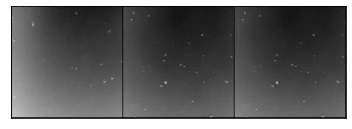

In [15]:
# Plot the images on their own
grid = make_grid(images[:3])
show(grid)

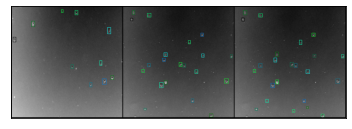

In [16]:
# And plot them with their bounding boxes

bbox_images = [
    draw_bounding_boxes((image*255).type(torch.uint8), bboxes) for image, bboxes in zip(images, bboxes)
]
grid = make_grid(bbox_images[:3])
show(grid)

In [17]:
# For the presentation, we need either a PCA or a t-SNE visualization. 
# We'll do a t-SNE. Since our images are already 2D, and the labels are just bounding boxes,
# we'll make a small adjustment to our metric. Rather than looking for bounding boxes, 
# t-SNE will reduce for the number of boxes.
from sklearn.manifold import TSNE

# We'll want all training images for this
images = []
bboxes = []
training_iter = iter(training_loader)
for data_batch in tqdm(training_iter, total=len(training_iter), ncols=100):
    for image, label_datum in vizualization_data:
        images.append(image)
        bboxes.append(label_datum[0])


tsne_images = [image.numpy() for image in images]

# Recall the original image is grayscale
tsne_images = np.array([image[0].flatten() for image in tsne_images])

# Labels will be the number of boxes in a given image
tsne_labels = np.array([len(image_bboxes) for image_bboxes in bboxes])


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.86it/s]


In [18]:
# Now we perform the t-SNE
tsne = TSNE(
    n_components=2, 
    random_state=1,
    perplexity=4
)

tsne_transform = tsne.fit_transform(tsne_images)

/home/simon/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simon/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


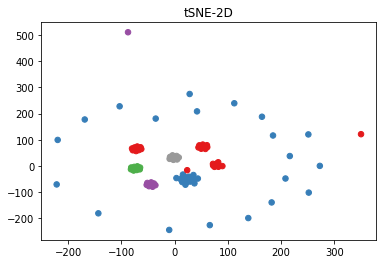

In [19]:
# And finally plot the result
plt.scatter(tsne_transform[:, 0], tsne_transform[:, 1], c= tsne_labels, s=30, cmap='Set1')
plt.title("tSNE-2D")
plt.show()

### Model Definition
As mentioned above, the we'll have to use transfer learning with a pre-existing model. In particular, we'll try fine-tuning PyTorch's `ssd300_vgg16`.

In [20]:
# Step 3 -- Define Model

# As stated, we're going to use a pretrained model
from torchvision.models.detection import SSD300_VGG16_Weights, ssd300_vgg16
weights = SSD300_VGG16_Weights
model = ssd300_vgg16(weights=weights.DEFAULT)

In [21]:
# Print out the base model
model

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [22]:
# To do tranfer learning, we'll freeze the head and body, replace the end classification head, 
# and leave the last few layer of localization head unfrozen.
import torch.nn as nn
for param in model.parameters():
    param.requires_grad = False
    
# Unfreeze some regression layers
params = model.head.regression_head.parameters()
for param in list(params)[-2:]:
    param.requires_grad = True
    
# Replace the classification head
new_head = ssd300_vgg16(num_classes=2).head.classification_head
model.head.classification_head = new_head


In [23]:
# Print out the new model
model

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [24]:
# Combine steps into a single function for later
def get_ssd_model():
    weights = SSD300_VGG16_Weights
    model = ssd300_vgg16(weights=weights.DEFAULT)

    for param in model.parameters():
        param.requires_grad = False
    
    params = model.head.regression_head.parameters()
    for param in list(params)[-2:]:
        param.requires_grad = True
    
    new_head = ssd300_vgg16(num_classes=2).head.classification_head
    model.head.classification_head = new_head
    return model


### Loss Function
The loss function requires some consideration, as there are multiple possible bounding boxes which may overlap in any number of ways. The loss we'll use is called Multibox loss. It involves a combination of localization loss -- which is based on the difference between the predicted bounding box and the (closest) corresponding ground truth coordinates -- and confidence loss -- which predicts the class of the object contained in the bounding box (in our case either foreground or background). Pytorch's `sdd300_vgg16` includes this loss as part of the model, but we'll define the loss function here nonetheless. The following is taken from [sgrvinod/a-PyTorch-Tutorial-to-Object-Detection](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection).

In [25]:
# Step 4 -- Define Loss

# The Multibox loss, from https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/model.py
import torch.nn as nn
class MultiBoxLoss(nn.Module):
    """
    The MultiBox loss, a loss function for object detection.
    This is a combination of:
    (1) a localization loss for the predicted locations of the boxes, and
    (2) a confidence loss for the predicted class scores.
    """

    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()
        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

        self.smooth_l1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduce=False)

    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        """
        Forward propagation.
        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param boxes: true  object bounding boxes in boundary coordinates, a list of N tensors
        :param labels: true object labels, a list of N tensors
        :return: multibox loss, a scalar
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).to(device)  # (N, 8732, 4)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).to(device)  # (N, 8732)

        # For each image
        for i in range(batch_size):
            n_objects = boxes[i].size(0)

            overlap = find_jaccard_overlap(boxes[i],
                                           self.priors_xy)  # (n_objects, 8732)

            # For each prior, find the object that has the maximum overlap
            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)  # (8732)

            # We don't want a situation where an object is not represented in our positive (non-background) priors -
            # 1. An object might not be the best object for all priors, and is therefore not in object_for_each_prior.
            # 2. All priors with the object may be assigned as background based on the threshold (0.5).

            # To remedy this -
            # First, find the prior that has the maximum overlap for each object.
            _, prior_for_each_object = overlap.max(dim=1)  # (N_o)

            # Then, assign each object to the corresponding maximum-overlap-prior. (This fixes 1.)
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(device)

            # To ensure these priors qualify, artificially give them an overlap of greater than 0.5. (This fixes 2.)
            overlap_for_each_prior[prior_for_each_object] = 1.

            # Labels for each prior
            label_for_each_prior = labels[i][object_for_each_prior]  # (8732)
            # Set priors whose overlaps with objects are less than the threshold to be background (no object)
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0  # (8732)

            # Store
            true_classes[i] = label_for_each_prior

            # Encode center-size object coordinates into the form we regressed predicted boxes to
            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)  # (8732, 4)

        # Identify priors that are positive (object/non-background)
        positive_priors = true_classes != 0  # (N, 8732)

        # LOCALIZATION LOSS

        # Localization loss is computed only over positive (non-background) priors
        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])  # (), scalar

        # Note: indexing with a torch.uint8 (byte) tensor flattens the tensor when indexing is across multiple dimensions (N & 8732)
        # So, if predicted_locs has the shape (N, 8732, 4), predicted_locs[positive_priors] will have (total positives, 4)

        # CONFIDENCE LOSS

        # Confidence loss is computed over positive priors and the most difficult (hardest) negative priors in each image
        # That is, FOR EACH IMAGE,
        # we will take the hardest (neg_pos_ratio * n_positives) negative priors, i.e where there is maximum loss
        # This is called Hard Negative Mining - it concentrates on hardest negatives in each image, and also minimizes pos/neg imbalance

        # Number of positive and hard-negative priors per image
        n_positives = positive_priors.sum(dim=1)  # (N)
        n_hard_negatives = self.neg_pos_ratio * n_positives  # (N)

        # First, find the loss for all priors
        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))  # (N * 8732)
        conf_loss_all = conf_loss_all.view(batch_size, n_priors)  # (N, 8732)

        # We already know which priors are positive
        conf_loss_pos = conf_loss_all[positive_priors]  # (sum(n_positives))

        # Next, find which priors are hard-negative
        # To do this, sort ONLY negative priors in each image in order of decreasing loss and take top n_hard_negatives
        conf_loss_neg = conf_loss_all.clone()  # (N, 8732)
        conf_loss_neg[positive_priors] = 0.  # (N, 8732), positive priors are ignored (never in top n_hard_negatives)
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)  # (N, 8732), sorted by decreasing hardness
        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).to(device)  # (N, 8732)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)  # (N, 8732)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]  # (sum(n_hard_negatives))

        # As in the paper, averaged over positive priors only, although computed over both positive and hard-negative priors
        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()  # (), scalar

        # TOTAL LOSS

        return conf_loss + self.alpha * loc_loss
    
    
# Additional functions used by the loss, from https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/utils.py
def cxcy_to_xy(cxcy):
    """
    Convert bounding boxes from center-size coordinates (c_x, c_y, w, h) to boundary coordinates (x_min, y_min, x_max, y_max).
    :param cxcy: bounding boxes in center-size coordinates, a tensor of size (n_boxes, 4)
    :return: bounding boxes in boundary coordinates, a tensor of size (n_boxes, 4)
    """
    return torch.cat([cxcy[:, :2] - (cxcy[:, 2:] / 2),  # x_min, y_min
                      cxcy[:, :2] + (cxcy[:, 2:] / 2)], 1)  # x_max, y_max

def find_intersection(set_1, set_2):
    """
    Find the intersection of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)

def find_jaccard_overlap(set_1, set_2):
    """
    Find the Jaccard Overlap (IoU) of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # Find intersections
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)

def cxcy_to_gcxgcy(cxcy, priors_cxcy):
    """
    Encode bounding boxes (that are in center-size form) w.r.t. the corresponding prior boxes (that are in center-size form).
    For the center coordinates, find the offset with respect to the prior box, and scale by the size of the prior box.
    For the size coordinates, scale by the size of the prior box, and convert to the log-space.
    In the model, we are predicting bounding box coordinates in this encoded form.
    :param cxcy: bounding boxes in center-size coordinates, a tensor of size (n_priors, 4)
    :param priors_cxcy: prior boxes with respect to which the encoding must be performed, a tensor of size (n_priors, 4)
    :return: encoded bounding boxes, a tensor of size (n_priors, 4)
    """

    # The 10 and 5 below are referred to as 'variances' in the original Caffe repo, completely empirical
    # They are for some sort of numerical conditioning, for 'scaling the localization gradient'
    # See https://github.com/weiliu89/caffe/issues/155
    return torch.cat([(cxcy[:, :2] - priors_cxcy[:, :2]) / (priors_cxcy[:, 2:] / 10),  # g_c_x, g_c_y
                      torch.log(cxcy[:, 2:] / priors_cxcy[:, 2:]) * 5], 1)  # g_w, g_h

def xy_to_cxcy(xy):
    """
    Convert bounding boxes from boundary coordinates (x_min, y_min, x_max, y_max) to center-size coordinates (c_x, c_y, w, h).
    :param xy: bounding boxes in boundary coordinates, a tensor of size (n_boxes, 4)
    :return: bounding boxes in center-size coordinates, a tensor of size (n_boxes, 4)
    """
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2,  # c_x, c_y
                      xy[:, 2:] - xy[:, :2]], 1)  # w, h


# Also need to define a device to run on, we'll stay in the cpu
device = torch.device("cpu")

In [26]:
# We instantiate the loss, and demonstrate its usage. 
# For training and testing, we'll use the loss provided with the model.

# Priors are the precomputed boxes the model uses as the starting point for estimation.
# Pytorch's version doesn't provide easy access to these, so we'll provide a fake one.
priors_cxcy = torch.tensor([[0.25,0.25,0.75,0.75]]) # (n_priors=1, 4)

criterion = MultiBoxLoss(priors_cxcy=priors_cxcy)

/home/simon/.local/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [27]:
# Here we demonstrate its usage.

# Forward prop.
# predicted_locs, predicted_scores = model(images)  # (N, n_priors, 4), (N, n_priors, n_classes)
predicted_locs = torch.tensor( # (N=1, n_priors=1, 4)
     [[[0.4, 0.5, 0.7, 0.8]]]
)
predicted_scores = torch.tensor( # (N=1, n_priors=1, n_classes=2)
    [[[0.2, 0.8]]] 
)

# We'll say the ground truth is a box [0.2, 0.2, 0.5, 0.5] with label [1]
boxes = [torch.tensor([[0.2, 0.2, 0.5, 0.5]])]
labels = [torch.tensor([[1]])]

# Loss
loss = criterion(predicted_locs, predicted_scores, boxes, labels)  # scalar

print(f'{loss=}')

loss=tensor(3.5449)


### Optimizer
Nothing fancy here, just a fine-tuned SGD.

In [28]:
# Step 5 -- Define Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Training
The training loop includes validation, checkpointing, and Weights and Biases integration.

In [29]:
# Step 6 -- Training

# Before proceeding, we need to correct the typing for the data.
# The model expects a list of tensors and list of dicts, so we'll provide a conversion function.

def package_batch(data_batch):
    images = []
    labels = []
    for image, label_datum in data_batch:
        images.append(image)
        labels.append({'boxes':label_datum[0], 'labels':label_datum[1]})
    return images, labels

# Following sgrvinod/a-PyTorch-Tutorial-to-Object-Detection, the combined loss is just the sum of the two losses.
def combined_loss(losses):
    return losses['bbox_regression']+losses['classification']


In [30]:
# Setup WandB integration
import wandb
wandb.init(project="cs6243")

# Record some cofiguration details. Most of these were used earlier, 
# but it is convenient to define them all together here.
config = wandb.config          # Initialize config
config.batch_size = 10          # input batch size for training (default: 64)
config.test_batch_size = 1    # input batch size for testing (default: 1000)
config.epochs = 10             # number of epochs to train (default: 10)
config.lr = 0.001               # learning rate (default: 0.01)
config.momentum = 0.9          # SGD momentum (default: 0.5) 
config.log_interval = 1     # how many batches to wait before logging training status

# Tell WandB to watch our model
wandb.watch(model, log="all")

wandb: Currently logged in as: bwinn. Use `wandb login --relogin` to force relogin


[]

In [31]:
# To capture images and their bounding box data, WandB expects a particular format for the bboxes and labels.
# The following functions makes the appropriate conversions. Note the input is the output of the 
# package_batch function.
class_id_to_label = {0:'background', 1:'foreground'}

def format_wandb_boxes(boxes, scores, classes, losses):
    box_data = []
    for i in range(boxes.size()[0]):
        box = boxes[i]
        box_data.append({
            "position": {
                "minX": int(box[0]),
                "maxX": int(box[2]),
                "minY": int(box[1]),
                "maxY": int(box[3])
            },
            "domain" : "pixel",
            "class_id" : classes[i].item(),
            "box_caption": class_id_to_label[classes[i].item()],
            "scores" : {
                "bbox_regression_loss": losses['bbox_regression'].item(),
                "classification_loss": losses['classification'].item(),
                "combined_loss": combined_loss(losses).item(),
                "score":scores[i].item(),
            },
        })
    return {'box_data':box_data, "class_labels": class_id_to_label}
        
def format_wandb_ground_truth(boxes):
    box_data = []
    for i in range(boxes.size()[0]):
        box = boxes[i]
        box_data.append({
            "position": {
                "minX": int(box[0]),
                "maxX": int(box[2]),
                "minY": int(box[1]),
                "maxY": int(box[3]),
            },
            "domain" : "pixel",
            "class_id" : 1,
            "box_caption": class_id_to_label[1],
            "scores" : {},
        })
        
    return {'box_data':box_data, "class_labels": class_id_to_label}

def generate_wandb_boxes(image, label, model):
    boxes = {}
    model.eval()
    predictions = model([image])
    model.train()
    losses = model([image], [label])
    predicted_boxes = predictions[0]['boxes']
    scores = predictions[0]['scores']
    classes = predictions[0]['labels']
    boxes['predictions']=format_wandb_boxes(predicted_boxes, scores, classes, losses)
    boxes['ground_truth']=format_wandb_ground_truth(label['boxes'])
    return boxes
    
    
def wandb_images(images, labels, model):
    wandb_images = []
    for image, label in zip(images,labels):
        wandb_images.append(wandb.Image(image, boxes=generate_wandb_boxes(image, label, model)))
    return wandb_images


In [32]:
# The main training loop.

num_epochs = 10
checkpoint_path = 'model_checkpoint'

# Logging all the images and their bounding boxes makes the training much slower, 
# disable that logging if you don't want it.
enable_wandb_logging = False

# Establish a list for your loss history
training_loss_history = list()
validation_loss_history = list()

for epoch in tqdm(range(num_epochs), total=num_epochs, ncols=100, desc=f'Training'):
    model.train()
    training_loss = 0.0
    training_images = []
    ## for each data batch 
    for i, data in enumerate(training_loader):
        images, labels = package_batch(data)
        #inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
    
        outputs = model(images, labels)
        loss = combined_loss(outputs)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()
        
        # Capture training images in WandB
        if enable_wandb_logging:
            training_images.extend(wandb_images(images, labels, model))
        
    training_loss_history.append(training_loss/len(training_loader))
    
    validation_loss = 0.0
    validation_images = []
    for i, data in enumerate(validation_loader):
        images, labels = package_batch(data)
        #inputs, labels = inputs.to(device), labels.to(device)
    
        outputs = model(images, labels)
        loss = combined_loss(outputs)

        validation_loss += loss.item()
        
        # Capture validation images in WandB
        if enable_wandb_logging:
            validation_images.extend(wandb_images(images, labels, model))
        
    validation_loss_history.append(validation_loss/len(validation_loader))
    
    state = {'epoch': epoch + 1, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), }
    torch.save(state, f'{checkpoint_path}')
    
    # WandB logging
    if enable_wandb_logging:
        wandb.log({
            'training_loss': training_loss/len(training_loader),
            'training_images': training_images,
            'validation_loss': validation_loss/len(validation_loader),
            'validation_images': validation_images,
        })

Training: 100%|█████████████████████████████████████████████████████| 10/10 [03:46<00:00, 22.64s/it]


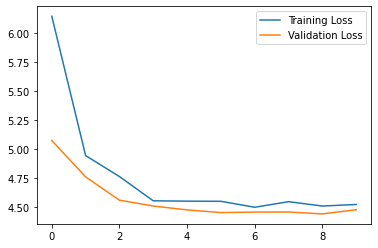

In [33]:
# Plot the losses
plt.plot(training_loss_history, label="Training Loss")
plt.plot(validation_loss_history, label="Validation Loss")
plt.legend()
plt.show()

### Select the Best Model

In [34]:
# Step 7 -- Select Best Model

# There's not a significant increase in the validation loss over the course of the training,
# so we'll simply load the fully trained model.

model = get_ssd_model()

checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

### Testing

In [35]:
# Step 8 -- Testing

# Testing is like training, we just don't do the backpropagation

model.train() # Still need training mode to get the loss.
test_loss = 0.0
## for each data batch 
for i, data in enumerate(testing_loader):
    images, labels = package_batch(data)
    #inputs, labels = inputs.to(device), labels.to(device)
    
    outputs = model(images, labels)
    loss = combined_loss(outputs)

    print(f'Test loss {i}:',loss.item())
    test_loss += loss.item()
    
print('Average testing loss:', test_loss/len(testing_loader))

Test loss 0: 4.125417709350586
Test loss 1: 3.358181953430176
Test loss 2: 4.298280715942383
Test loss 3: 4.130422115325928
Test loss 4: 3.815868854522705
Test loss 5: 3.9580931663513184
Test loss 6: 5.95512580871582
Test loss 7: 3.7564055919647217
Test loss 8: 5.439889907836914
Test loss 9: 3.668339252471924
Test loss 10: 4.614912033081055
Test loss 11: 6.0680975914001465
Test loss 12: 4.670401573181152
Test loss 13: 3.598750114440918
Test loss 14: 7.50931453704834
Test loss 15: 4.818495750427246
Test loss 16: 5.184601306915283
Test loss 17: 4.425426483154297
Test loss 18: 3.0625574588775635
Test loss 19: 3.306539535522461
Average testing loss: 4.4882560729980465


In [36]:
# Lets compare the predicted boxes in one image against the actual

test_iter = iter(testing_loader)
images, labels = package_batch(next(test_iter))

image, actual_bboxes = images[0], labels[0]['boxes']
model.eval()
predictions = model(images)
print(predictions)

[{'boxes': tensor([[176.0662,  64.5681, 188.6967,  76.5186],
        [ 79.1409,  53.2701,  88.7065,  68.0544],
        [ 53.0294,  88.4208,  65.9330, 100.4645],
        [217.5472,  40.0512, 227.4697,  55.1255],
        [265.5559,  80.0162, 271.4068,  90.3877],
        [200.9256, 203.6857, 209.5708, 212.6429],
        [167.2588, 190.1785, 175.6312, 202.0306],
        [109.4746, 233.5532, 115.3362, 241.0978],
        [ 27.7354,  31.1306,  40.7399,  42.8583],
        [ 92.7010,  15.5325, 108.4638,  28.6232],
        [174.6145,  63.7849, 192.0284,  83.7410],
        [202.0297, 144.7893, 209.7060, 158.1029],
        [ 41.8449,  86.6975,  51.5242,  98.4299],
        [ 21.0689, 153.8256,  28.4761, 162.9470],
        [ 22.8526,  11.9336,  33.7439,  29.3393],
        [207.1589,  93.2900, 215.8194, 110.1915],
        [171.5562, 236.8557, 177.2100, 251.8681],
        [222.8503, 153.3940, 231.3247, 165.6991],
        [278.1761, 268.2437, 292.7867, 285.2626],
        [ 65.3486, 239.5291,  71.1806, 

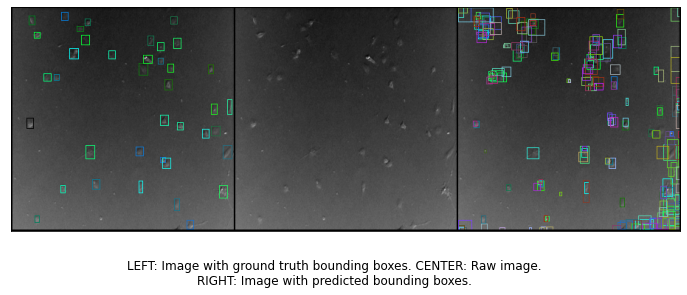

In [37]:
# Graphing them side by side. 

plt.rcParams["figure.figsize"] = (12,9)

predicted_bboxes = predictions[0]['boxes']
images = [
    draw_bounding_boxes((image*255).type(torch.uint8), actual_bboxes),
    (image*255).type(torch.uint8),
    draw_bounding_boxes((image*255).type(torch.uint8), predicted_bboxes),
]
grid = torchvision.utils.make_grid(images)

figtext = 'LEFT: Image with ground truth bounding boxes. CENTER: Raw image.\nRIGHT: Image with predicted bounding boxes.'
show(grid, figtext)


### Results
Examining the results, we note several issues. The model produces several overlapping bounding boxes, creating numerous boxes containing only part of the object of interest. Additionally, the model is much more sensitive to distrubances in the image, producing boxes around objects that are not marked out in the ground truth reference. This includes a large number of boxes placed on the edge of the image.

Looking at data recorded by WandB is not particularly enlightening, especially the logged images, which are too visually busy to be analyzed fruitfully.

### Conclusion
In this notebook, we've gone through eight steps to create, train, and test a model for creating bounding boxes on preprocessed images of microglia. To do so, we have performed numerous conversions and visualizations, utilized transfer learning via a pretrained `ssd300_vgg16` model, reviewed the `Multibox` loss, trained with WandB logging, and used test images to evalute the trained model.

While the results obtained are not quite usable, they do show promise as the model does seem to accurately include the objects of interest as in the ground truth. This is encouraging, especially considering the small amount of training data. A larger amount of high quality data would allow further training, including the possibility of retraining the encoder, which could make the model into a more usable tool.